In [2]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, seed

from mpl_toolkits import mplot3d

from echo_state_network import ESN

Equation for the first pendulum: $mL\ddot{\theta_{1}} = -gmsin(\theta_{1}) - kLsin(\theta_{1} - \theta_{2})$

Equation for the second pendulum: $mL\ddot{\theta_{2}} = -gmsin(\theta_{2}) + kLsin(\theta_{1} - \theta_{2})$

# Equation independent of the second angle to get started

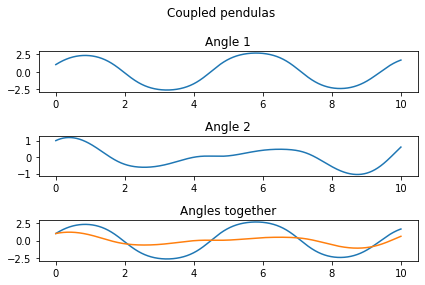

In [3]:
L_1 = 3
g_1 = 9.81
k_1 = 2
m_1 = 2

def coupled_pendulum(w, t, p):
    # x_i = theta_i
    # y_i = theta_i'
    # Return [theta1', theta1'', theta2', theta2'']
    # In our terminology: [y1, y1', y2, y2']
    
    x1, y1, x2, y2 = w
    g, L, k, m = p
    
    theta1_double_prime = - g/L * np.sin(x1) - k/m * np.sin(x1 - x2) # Phase difference
    theta2_double_prime = - g/L * np.sin(x2) - k/m * np.sin(x2 - x1) # Phase difference, but adjusted for -
    
    return [y1, theta1_double_prime, y2, theta2_double_prime]


def compute_L2(data1, data2):
    return ((data1 - data2) ** 2).sum()


def getESN(input_channels, n_reservoir, spectral_radius, sparsity, noise, teacher_forcing):
    return ESN(
        input_channels, 
        1, 
        n_reservoir=n_reservoir,
        spectral_radius=spectral_radius,
        sparsity=sparsity,
        noise=noise, 
        input_shift=None,
        input_scaling=None, 
        teacher_forcing=teacher_forcing, 
        feedback_scaling=None,
        teacher_scaling=None, 
        teacher_shift=None,
        out_activation=lambda x: x, #tanh, sigmoid
        inverse_out_activation=lambda x: x, #TODO ?
        random_state=None, 
        silent=True
    )

t = np.linspace(0, 10, num=10000)

# Pack up the parameters and initial conditions:
p = [g_1, L_1, k_1, m_1]

#Initial values
w0 = [1, 3, 1, 1]

abserr = 1.0e-8
relerr = 1.0e-6

# Call the ODE solver.
solution = odeint(coupled_pendulum, w0, t, args=(p,), atol=abserr, rtol=relerr)
angle1 = solution[:, 0]
angle2 = solution[:, 2]

fig, axs = plt.subplots(3)
fig.suptitle('Coupled pendulas')

axs[0].set_title('Angle 1')
axs[1].set_title('Angle 2')
axs[2].set_title('Angles together')
fig.tight_layout()

axs[0].plot(t, angle1)
axs[1].plot(t, angle2)
axs[2].plot(t, angle1, t, angle2)

## Metrics on data

Text(0, 0.5, 'STD')

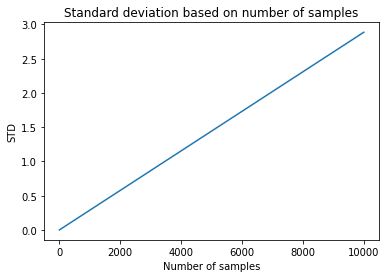

In [4]:
standard_deviations = []

for i in range(2, len(t)):
    standard_deviations.append(t[:i].std())


plt.plot(range(2, len(t)), standard_deviations)
plt.title('Standard deviation based on number of samples')
plt.xlabel('Number of samples')
plt.ylabel('STD')

## Predictions on the first angle using ESN, numerical solution using time input

0.4140142480127964 Sum square


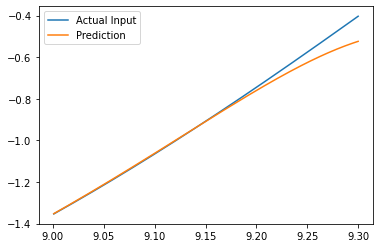

In [6]:
# Selected experimentally

global_reservoir_size = 2000
global_spectral_radius = 0.5
global_sparsity = 0.35
global_noise = 0
global_teacher_forcing = False

best_iterations = 3

def get_global_esn():
    return getESN(
        1, 
        global_reservoir_size, 
        global_spectral_radius, 
        global_sparsity, 
        global_noise, 
        global_teacher_forcing
    )

esn = get_global_esn()

cutoff = int(len(t) * 0.9)

t_train = t[:cutoff]
y_train = angle1[:cutoff]
t_test = t[cutoff:]
y_test = angle1[cutoff:]

N_samples = 300
weights = esn.fit(t_train, y_train)
pred = esn.predict(t_test[:N_samples], True)[:, 0]

print(((pred - y_test[:N_samples]) ** 2).sum(), 'Sum square')

plt.plot(t_test[:N_samples], y_test[:N_samples], t_test[:N_samples], pred)
plt.legend(['Actual Input', 'Prediction'])

# Error analysis of time series prediction using time input

## L2 distance on step size normalized by variance

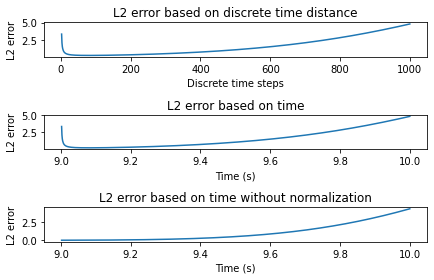

In [91]:
errs = []
non_normalized_err = []
pred = esn.predict(t_test)[:, 0]

N_reservoir_size_samples = 1000

for i in range(2, N_reservoir_size_samples + 1):
    ground_truth = y_test[:i]
    error = np.abs(pred[:i] - ground_truth).mean()
    
    local_error = error / ground_truth.std()
    
    errs.append(local_error) 
    non_normalized_err.append(error)
    
fig, ax = plt.subplots(3)
    
ax[0].plot(list(range(2, N_reservoir_size_samples + 1)), errs)
ax[0].set_title('L2 error based on discrete time distance')
ax[0].set_xlabel('Discrete time steps')
ax[0].set_ylabel('L2 error')

ax[1].plot(t_test[1:N_reservoir_size_samples], errs)
ax[1].set_title('L2 error based on time')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('L2 error')

ax[2].plot(t_test[1:N_reservoir_size_samples], non_normalized_err)
ax[2].set_title('L2 error based on time without normalization')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('L2 error')

fig.tight_layout()

#It's possible that variance in data grows exponentially

## L2 distance based on reservoir size

In this step we will fix the time steps at 300, spectral radius at 0.5, sparsity at 0.2, noise at 0. The number of reservoirs will be increased in increments of a 100, and will go from a 100 to 2000

Processing number of reservoirs: 100
Processing number of reservoirs: 200
Processing number of reservoirs: 300
Processing number of reservoirs: 400
Processing number of reservoirs: 500
Processing number of reservoirs: 600
Processing number of reservoirs: 700
Processing number of reservoirs: 800
Processing number of reservoirs: 900
Processing number of reservoirs: 1000
Processing number of reservoirs: 1100
Processing number of reservoirs: 1200
Processing number of reservoirs: 1300
Processing number of reservoirs: 1400
Processing number of reservoirs: 1500
Processing number of reservoirs: 1600
Processing number of reservoirs: 1700
Processing number of reservoirs: 1800
Processing number of reservoirs: 1900
Processing number of reservoirs: 2000


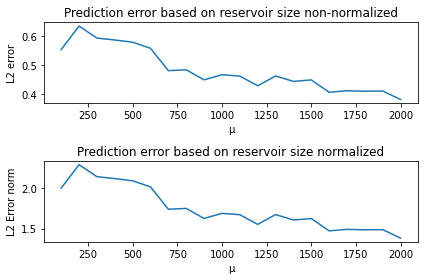

In [93]:
err = []
err_normalized = []
steps = list(range(100, 2001, 100))

def get_esn_modified_size(number_of_reservoirs):
    return getESN(
        1, 
        number_of_reservoirs, 
        global_spectral_radius, 
        global_sparsity, 
        global_noise, 
        global_teacher_forcing
    )

for number_of_reservoirs in steps:
    m = []
    m2 = []
    
    print('Processing number of reservoirs:', number_of_reservoirs)
    
    for _ in range(10):
        esn = get_esn_modified_size(number_of_reservoirs)
        weights = esn.fit(t_train, y_train)
        
        pred = esn.predict(t_test[:N])
        
        m.append(np.abs(pred - y_test[:N]).mean())
        m2.append(np.abs(pred - y_test[:N]).mean() / y_test[:N].std())
        
    err_normalized.append(np.array(m2).mean())
    err.append(np.array(m).mean())

fig, ax = plt.subplots(2)

ax[0].plot(steps, err)
ax[0].set_title('Prediction error based on reservoir size non-normalized')
ax[0].set_xlabel('\u03BC')
ax[0].set_ylabel('L2 error')

ax[1].plot(steps, err_normalized)
ax[1].set_title('Prediction error based on reservoir size normalized')
ax[1].set_xlabel('\u03BC')
ax[1].set_ylabel('L2 Error norm')

fig.tight_layout()

fig.savefig('Error on reservoir size', bbox_inches='tight')

# Mean squared error, normalize with respect to the variance
# After 1500 not much improvement

## Error dependece on sparsity

Processing sparsity: 0.05
Processing sparsity: 0.1
Processing sparsity: 0.15000000000000002
Processing sparsity: 0.2
Processing sparsity: 0.25
Processing sparsity: 0.3
Processing sparsity: 0.35000000000000003
Processing sparsity: 0.4
Processing sparsity: 0.45
Processing sparsity: 0.5
Processing sparsity: 0.55
Processing sparsity: 0.6000000000000001
Processing sparsity: 0.6500000000000001
Processing sparsity: 0.7000000000000001
Processing sparsity: 0.7500000000000001
Processing sparsity: 0.8
Processing sparsity: 0.8500000000000001
Processing sparsity: 0.9000000000000001
Processing sparsity: 0.9500000000000001


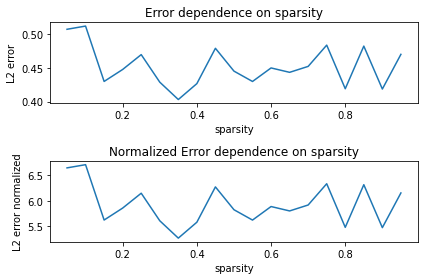

In [49]:
err = []
err_normalized = []
steps = np.arange(0.05, 1, 0.05)


for sparsity in steps:
    m = []
    m2 = []
    
    print('Processing sparsity:', sparsity)
    
    for _ in range(10):
        esn = getESN(1, 1000, 0.5, sparsity, 0, False)
        weights = esn.fit(t_train, y_train)
        
        pred = esn.predict(t_test[:N])
        
        m.append(np.abs(pred - y_test[:N]).mean())
        m2.append(np.abs(pred - y_test[:N]).mean() / y_test[:N].var())
        
    err.append(np.array(m).mean())
    err_normalized.append(np.array(m2).mean())
    
    
# Sparsity is related to spectral radius

# TODO: Check relation to sparsity and spectral radius
# TODO: Do a 2D plot of spectral radius, and sparsity in comparison to error

fig, ax = plt.subplots(2)

ax[0].plot(steps, err)
ax[0].set_title('Error dependence on sparsity')
ax[0].set_xlabel('sparsity')
ax[0].set_ylabel('L2 error')

ax[1].plot(steps, err_normalized)
ax[1].set_title('Normalized Error dependence on sparsity')
ax[1].set_xlabel('sparsity')
ax[1].set_ylabel('L2 error normalized')

fig.tight_layout()

# plt.plot(steps, err)

## Error dependence on spectral radius

Processing spectral radius: 0.1
Processing spectral radius: 0.2
Processing spectral radius: 0.30000000000000004
Processing spectral radius: 0.4
Processing spectral radius: 0.5
Processing spectral radius: 0.6
Processing spectral radius: 0.7000000000000001
Processing spectral radius: 0.8
Processing spectral radius: 0.9
Processing spectral radius: 1.0
Processing spectral radius: 1.1
Processing spectral radius: 1.2000000000000002
Processing spectral radius: 1.3000000000000003
Processing spectral radius: 1.4000000000000001
Processing spectral radius: 1.5000000000000002
Processing spectral radius: 1.6
Processing spectral radius: 1.7000000000000002
Processing spectral radius: 1.8000000000000003
Processing spectral radius: 1.9000000000000001
Processing spectral radius: 2.0


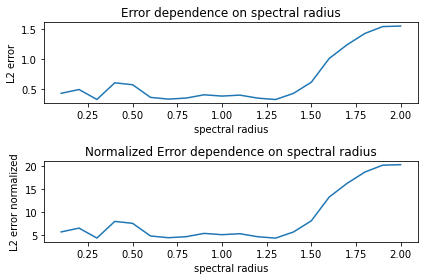

In [48]:
err = []
err_normalized = []
steps = np.arange(0.1, 2.1, 0.1)

for spectral_radius in steps:
    m = []
    m2 = []
    
    print('Processing spectral radius:', spectral_radius)
    
    for _ in range(10):
        esn = getESN(1, 500, spectral_radius, 0.1, 0, False)
        weights = esn.fit(t_train, y_train)
        
        pred = esn.predict(t_test[:N])
        
        m.append(np.abs(pred - y_test[:N]).mean())
        m2.append(np.abs(pred - y_test[:N]).mean() / y_test[:N].var())
        
    err.append(np.array(m).mean())
    err_normalized.append(np.array(m2).mean())
    
fig, ax = plt.subplots(2)

ax[0].plot(steps, err)
ax[0].set_title('Error dependence on spectral radius')
ax[0].set_xlabel('spectral radius')
ax[0].set_ylabel('L2 error')

ax[1].plot(steps, err_normalized)
ax[1].set_title('Normalized Error dependence on spectral radius')
ax[1].set_xlabel('spectral radius')
ax[1].set_ylabel('L2 error normalized')

fig.tight_layout()

## Relationship between spectral radius and sparsity

Total samples to process: 380
Processed: 0.2631578947368421
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 0.5263157894736842
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 0.7894736842105263
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 1.0526315789473684
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 1.3157894736842104
Processing internal training: 1
Processing internal 

Processed: 10.0
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 10.263157894736842
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 10.526315789473683
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 10.789473684210527
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 11.052631578947368
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3


Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 20.0
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 20.263157894736842
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 20.526315789473685
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 20.789473684210527
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 

Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 29.736842105263158
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 30.0
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 30.263157894736842
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 30.526315789473685
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 

Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 39.473684210526315
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 39.73684210526316
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 40.0
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 40.26315789473684
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 40.526315789473685
Pr

Processing internal training: 6
Processed: 49.21052631578947
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 49.473684210526315
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 49.73684210526316
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 50.0
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 50.26315789473684
Processing internal training: 1
Processing internal training: 2
Pro

Processed: 58.94736842105262
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 59.210526315789465
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 59.473684210526315
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 59.73684210526316
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 60.0
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Pr

Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 68.94736842105263
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 69.21052631578948
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 69.47368421052632
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 69.73684210526315
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal 

Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 78.6842105263158
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 78.94736842105263
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 79.21052631578948
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 79.47368421052632
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 79.7368421

Processing internal training: 6
Processed: 88.42105263157895
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 88.68421052631578
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 88.94736842105263
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 89.21052631578948
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 89.47368421052632
Processing internal training: 1
Processing internal tra

Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 98.42105263157895
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 98.68421052631578
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 98.94736842105263
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal training: 5
Processing internal training: 6
Processed: 99.21052631578947
Processing internal training: 1
Processing internal training: 2
Processing internal training: 3
Processing internal training: 4
Processing internal 

Text(0.5, 0.92, 'Spectral Radius and Sparsity relation to L2 Error')

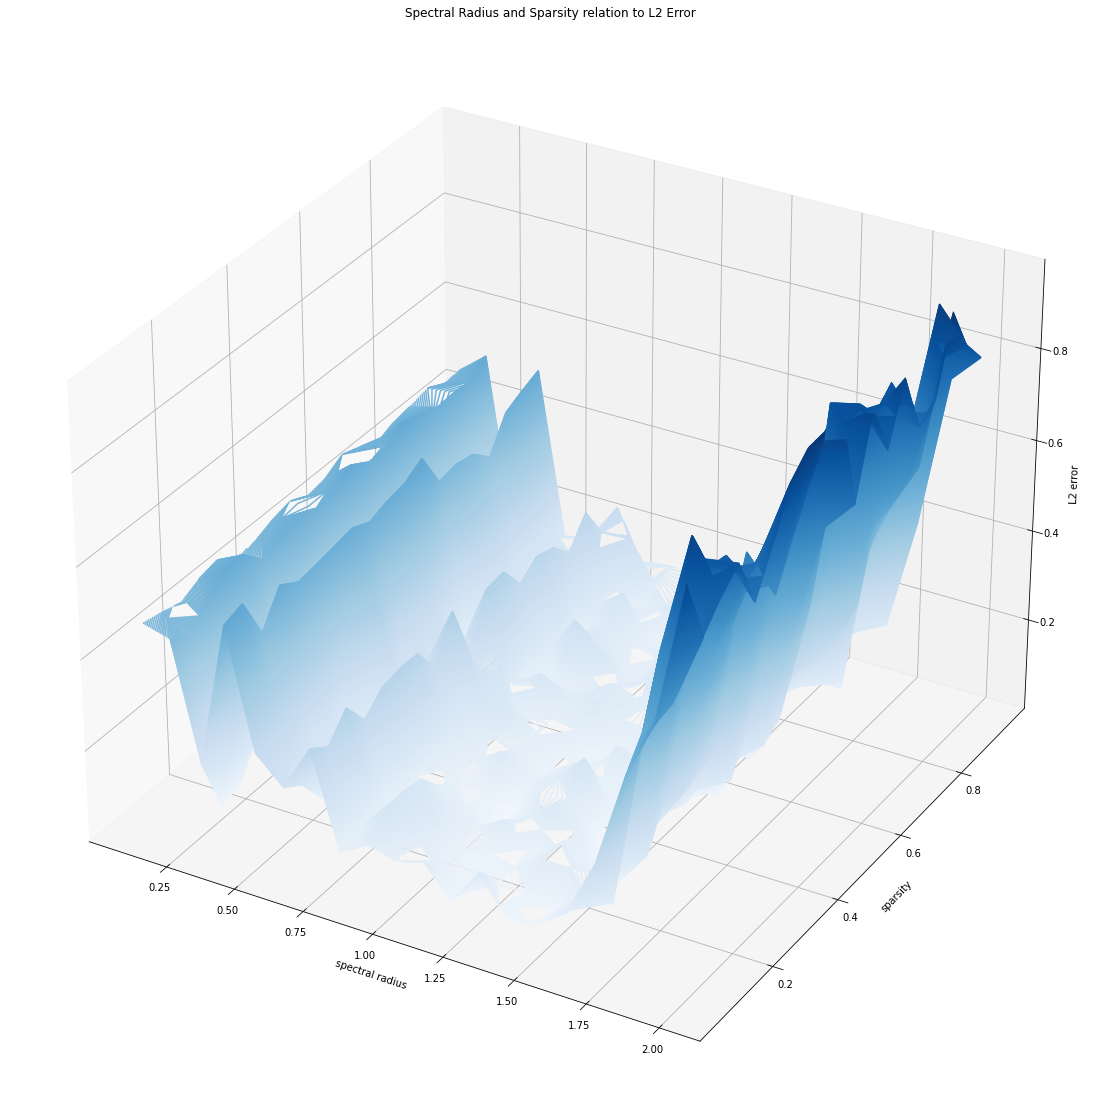

In [29]:
sparsities_list = np.arange(0.05, 1, 0.05)
spectral_radius_list = np.arange(0.1, 2.1, 0.1)

def get_esn_with_radius_and_sparsity(radius, sparsity):
    return getESN(
        1, 
        1000, #This is needed to reduce computation time, theoretically should only result to a shift
        radius, 
        sparsity, 
        global_noise, 
        global_teacher_forcing
    )
                                                                                                                                                                                                                                 
errors = []

total = len(sparsities_list) * len(spectral_radius_list)
counter = 1
N = 300

print('Total samples to process:', total)

for sparsity in sparsities_list:
    temp = []
    for spectral_radius in spectral_radius_list:
        
        print('Processed:', counter / total * 100)
        counter += 1
    
        err_list = []
        for _ in range(6):
            print('Processing internal training:', _ + 1)
            
            esn = get_esn_with_radius_and_sparsity(spectral_radius, sparsity)
            esn.fit(t_train, y_train)
            
            pred = esn.predict(t_test[:N])[:, 0]
            
            err_list.append(np.abs(pred - y_test[:N]).mean())
            
        temp.append(np.array(err_list).mean())
    
    errors.append(temp)


X, Y = np.meshgrid(spectral_radius_list, sparsities_list)

fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, errors, 1000, cmap='Blues')

ax.set_xlabel('spectral radius')
ax.set_ylabel('sparsity')
ax.set_zlabel('L2 error')
ax.set_title('Spectral Radius and Sparsity relation to L2 Error')

# Prediction with second angle as input

Text(0.5, 1.0, 'Angle prediction based on time and angle')

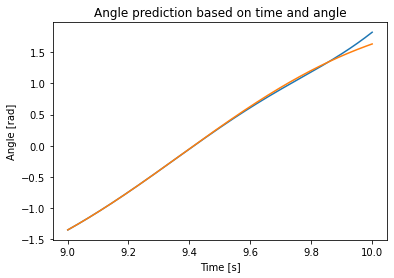

In [37]:
training_data_input = np.column_stack((t[:cutoff], angle2[:cutoff]))
training_data_output = angle1[:cutoff]

validation_data_input = np.column_stack((t[cutoff:], angle2[cutoff:]))
validation_data_output = angle1[cutoff:]

esn = getESN(2, 2000, 0.5, 0.2, 0, False)

weights = esn.fit(training_data_input, training_data_output)

pred = esn.predict(validation_data_input)[:,0]

print('L2 loss:', compute_L2(pred, validation_data_output))

plt.plot(validation_data_input[:,0], pred, validation_data_input[:, 0], validation_data_output)
plt.xlabel('Time [s]') 
plt.ylabel('Angle [rad]')
plt.title('Angle prediction based on time and angle')

# Look into synchrony between input parameters and reservoir states

## Prediction error with respect to reservoir size

In [ ]:
steps_list = list(range(100, 2001, 100))
err = []

# for ste

# Analytic approximation

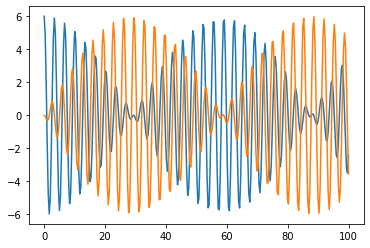

In [142]:
# https://phys.libretexts.org/Bookshelves/University_Physics/Book%3A_Mechanics_and_Relativity_(Idema)/08%3A_Oscillations/8.04%3A_Coupled_Oscillators
def compute_angles(time, initial_angle, k, g, l):
    omega_prime = np.sqrt(2 * k + g/l)
    omega_0 = np.sqrt(g/l)
    inner_term_1 = ((omega_0 + omega_prime) / 2) * t 
    inner_term_2 = ((omega_0 - omega_prime) / 2) * t
    
    angle1 = initial_angle * np.cos(inner_term_1) * np.cos(inner_term_2)
    angle2 = initial_angle * np.sin(inner_term_1) * np.sin(inner_term_2)
    
    return angle1, angle2

t = np.linspace(0, 100, 300)
initial_angle = 6
k = 0.2
g = 9.81
l = 3

angle1, angle2 = compute_angles(t, initial_angle, k, g, l)

plt.plot(t, angle1, t, angle2)

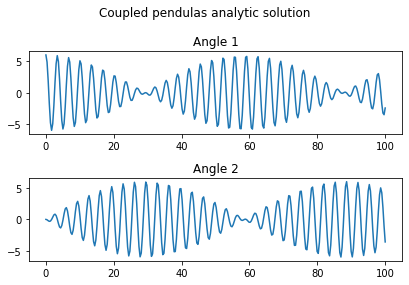

In [143]:
fig, axs = plt.subplots(2)
fig.suptitle('Coupled pendulas analytic solution')

axs[0].set_title('Angle 1')
axs[1].set_title('Angle 2')
fig.tight_layout()

axs[0].plot(t, angle1)
axs[1].plot(t, angle2)

# Predicting Angle 1 of coupled pendulum analytical solution with small angle approximation

harvesting states...
fitting...
training error:
2.606965194083856
L^2 error 2220240.121911047


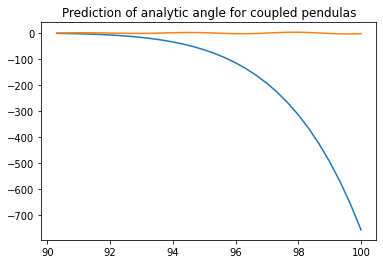

In [144]:
esn = getESN(1, 600, 0.2, 0.1, 0, False)

cutoff = int(len(t) * 0.9)

training_data_output = angle1[:cutoff]
training_data_input = t[:cutoff]

validation_data_output = angle1[cutoff:]
validation_data_input = t[cutoff:]

weights = esn.fit(training_data_input, training_data_output)

prediction = esn.predict(validation_data_input)[:,0]

plt.plot(validation_data_input, prediction, validation_data_input, validation_data_output)
plt.title('Prediction of analytic angle for coupled pendulas')

print('L^2 error', compute_L2(validation_data_output, prediction))

# Introducing 2nd channel, the angle of the 2nd pendulum

harvesting states...
fitting...
training error:
0.20678164261172358


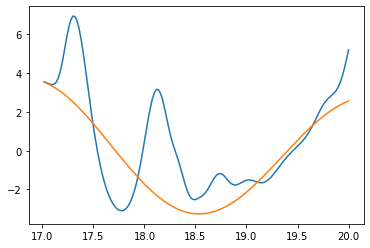

In [126]:
esn = getESN(2, 1000, 1, 0.3, 0, False)

angle_training_input = angle2[:cutoff]
time_training_input = t[:cutoff]

angle_validation_input = angle2[cutoff:]
time_validation_input = t[cutoff:]

training_data_input = np.column_stack((time_training_input, angle_training_input))
validation_data_input = np.column_stack((time_validation_input, angle_validation_input))

weights = esn.fit(training_data_input, training_data_output)

prediction = esn.predict(validation_data_input)[:,0]

plt.plot(time_validation_input, prediction, time_validation_input, validation_data_output)